<a href="https://colab.research.google.com/github/kebabee/Machine-Learning/blob/main/adadelta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from torch.utils.data import DataLoader, TensorDataset

# 7.1 Custom optimizer
Read the review arxiv:1609.04747. Then choose one of the algorithms from section 4 and implement. It should optimize of the function of the form loss(*params).


## 7.1.1 Adadelta algorithm

Adadelta is an extension of Adagrad that eliminates the need to manually set the global learning rate. The main idea is to adapt learning rate based on parameters update. It is done by multiplying the gradient by the ratio of the RMS coefficients described below.

General equation:
$$\Delta \theta = - \frac{RMS[\Delta \theta]_{t-1}}{RMS[g]_t} \cdot g_t$$

$$\theta_{t-1} = \theta_i + \Delta \theta_i$$

where $\theta_t$ stand for parameters in time step *t* and $g_t$ stand for gradient in time step *t*.

$RMS[g]_t$ is root mean squared of gradient *running average* E:
$$RMS[g]_t = \sqrt{E[g^2]_t + \epsilon}$$

$$E[g^2]_t = \gamma E[g^2]_{t-1} + (1 - \gamma) \cdot g^2$$
Default $\gamma$ equals 0.9.

$RMS[\Delta \theta]_t$ should be calculated similarly, but we do not know the update in time step *t*. It is approximated with $RMS[\Delta \theta]_{t-1}$.

## 7.1.2 Adadelta optimizer

In [4]:
class Adadelta:
    def __init__(self, params, gamma=0.9, epsilon=1e-6):
        self.params = list(params)
        self.gam = gamma
        self.eps = epsilon
        self.state = {}  # for E[g^2]_t and E[∆θ^2]_t

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()

    def step(self):
        for p in self.params:
            grad = p.grad # g_t
            state = self.state.get(p, {}) # different state for every data parameter

            if len(state) == 0: # if it is the first step of optimization
                state['E_g2'] = torch.zeros_like(p.data)  # E[g^2]_t
                state['E_theta2'] = torch.zeros_like(p.data)  # E[∆θ^2]_t
            E_g2, E_theta2 = state['E_g2'], state['E_theta2']
            gam, eps = self.gam, self.eps

            # update running averages E[g^2]_t
            E_g2.mul_(gam).addcmul_(1 - gam, grad, grad) # gamma * E[g^2]_{t-1} + (1 - gamma) * g_t * g_t

            rms_g = E_g2.add(eps).sqrt_()  # RMS[g] = sqrt(E[g^2]_t + eps)
            rms_theta = E_theta2.add(eps).sqrt_() # RMS[∆θ^2] = sqrt(E[∆θ^2]_t + eps)

            # update ∆θ_t
            delta = rms_theta.div_(rms_g).mul_(-1).mul_(grad)

            p.data.add_(delta) # update parameters
            E_theta2.mul_(gam).addcmul_(1 - gam, delta, delta)  # update E[∆θ^2]_t


## 7.1.3 Example - Adadelta in simple neural network

Minimizing loss for 3 layer naural network, make_moons dataset with 2 parameters.

My implementation vs PyTorch Adadelta

In [17]:
X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 1)  # output dimension is 1

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 10 models with my Adadelta
models1 = []
optimizers1 = []
criterion = nn.MSELoss()
losses1 = [[],[],[],[],[],[],[],[],[],[]]
for i in range(10):
  models1.append(SimpleModel())
  optimizers1.append(Adadelta(models1[i].parameters()))

for j in range(len(models1)):
  for i in range(1000):
    optimizers1[j].zero_grad()
    output = models1[j](X_train)
    loss = criterion(output, y_train.view(-1, 1))
    loss.backward()
    optimizers1[j].step()
    losses1[j].append(loss.item())


# 10 models with PyTorch's Adadelta
models2 = []
optimizers2 = []
criterion = nn.MSELoss()
losses2 = [[],[],[],[],[],[],[],[],[],[]]
for i in range(10):
  models2.append(SimpleModel())
  optimizers2.append(optim.Adadelta(models2[i].parameters()))

for j in range(len(models2)):
  for i in range(1000):
    optimizers2[j].zero_grad()
    output = models2[j](X_train)
    loss = criterion(output, y_train.view(-1, 1))
    loss.backward()
    optimizers2[j].step()
    losses2[j].append(loss.item())

print(f"\nMy Adadelta best loss: {np.min(losses1)}")
print(f"\nPyTorch Adadelta best loss: {np.min(losses2)}")


My Adadelta best loss: 0.013551183976233006

PyTorch Adadelta best loss: 0.018315957859158516


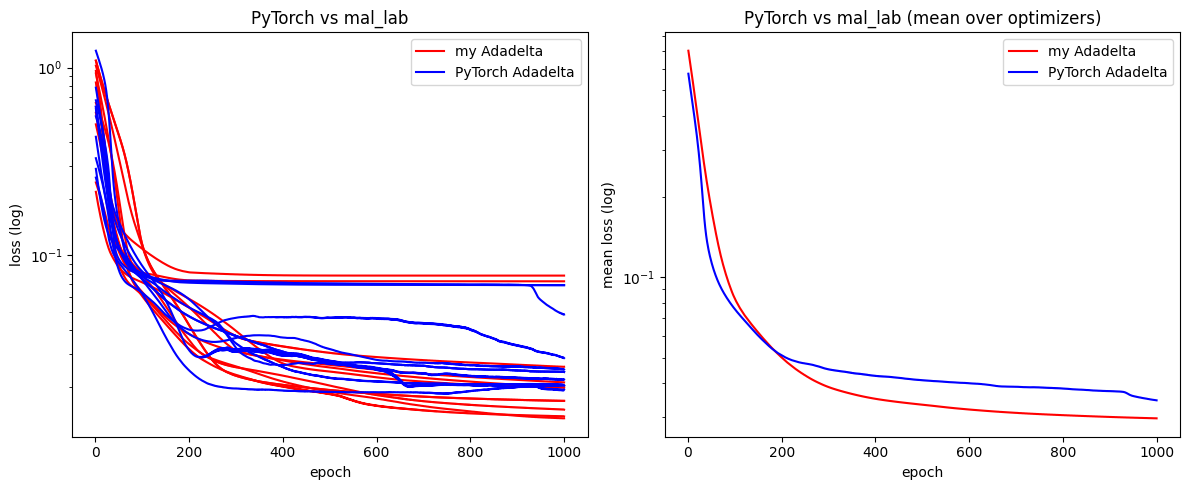

In [18]:
means1 = np.mean(losses1, axis=0)
means2 = np.mean(losses2, axis=0)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# all optimizers graph
axs[0].set_title('PyTorch vs mal_lab')
for lss in losses1:
    axs[0].plot(np.linspace(1, len(lss), len(lss)), lss, color='red')
axs[0].plot(np.linspace(1, len(losses1[0]), len(losses1[0])), losses1[0], color='red', label='my Adadelta')
for lss in losses2:
    axs[0].plot(np.linspace(1, len(lss), len(lss)), lss, color='blue')
axs[0].plot(np.linspace(1, len(losses2[0]), len(losses2[0])), losses2[0], color='blue', label='PyTorch Adadelta')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss (log)')
axs[0].set_yscale('log')
#axs[0].set_xscale('log')
axs[0].legend()

# means graph
axs[1].set_title('PyTorch vs mal_lab (mean over optimizers)')
axs[1].plot(np.linspace(1, len(means1), len(means1)), means1, color='red', label='my Adadelta')
axs[1].plot(np.linspace(1, len(means2), len(means2)), means2, color='blue', label='PyTorch Adadelta')
axs[1].legend()
axs[1].set_yscale('log')
#axs[1].set_xscale('log')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('mean loss (log)')

plt.tight_layout()
plt.show()

## 7.1.4 Example - more parameters

Minimizing loss for 4-layer neural network, iris dataset with 4 parameters.

My Adadelta loss minimizing process:
epoch 20, loss 0.0947
epoch 40, loss 0.0456
epoch 60, loss 0.0356
epoch 80, loss 0.0154
epoch 100, loss 0.0828
epoch 120, loss 0.0446
epoch 140, loss 0.0226
epoch 160, loss 0.0521
epoch 180, loss 0.0315
epoch 200, loss 0.0565

PyTorch Adadelta loss minimizing process:
epoch 20, loss 0.1264
epoch 40, loss 0.0385
epoch 60, loss 0.0260
epoch 80, loss 0.0217
epoch 100, loss 0.0064
epoch 120, loss 0.0259
epoch 140, loss 0.0393
epoch 160, loss 0.0099
epoch 180, loss 0.0002
epoch 200, loss 0.0050


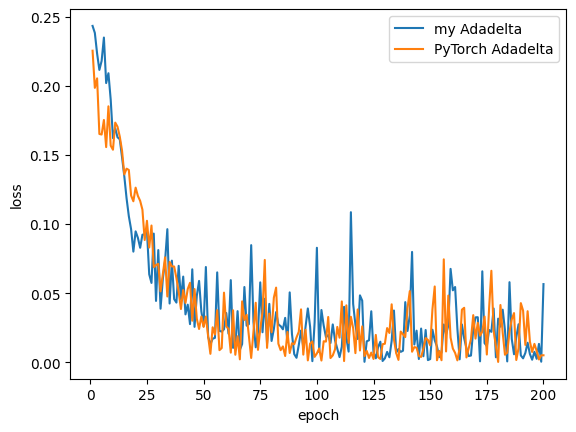


My Adadelta best loss with MSELoss: 0.000304

PyTorch Adadelta best loss with MSELoss: 0.000228


In [14]:
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

class SimpleClassifier(nn.Module):
    def __init__(self):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(4, 12)
        self.fc2 = nn.Linear(12, 6)
        self.fc3 = nn.Linear(6, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.softmax(x, dim=1)  # softmax on output, result is array with probabilities of each class

model1 = SimpleClassifier()
criterion = nn.MSELoss()
optimizer1 = Adadelta(model1.parameters())

losses1 = []

model2 = SimpleClassifier()
optimizer2 = optim.Adadelta(model2.parameters())

losses2 = []

epochs = 200

print("My Adadelta loss minimizing process:")
for i in range(epochs):
    for inputs, labels in train_loader:
        optimizer1.zero_grad()
        outputs1 = model1(inputs)
        loss1 = criterion(outputs1, torch.eye(3)[labels])  # torch.eye - macierz diagonalna z jedynek
        loss1.backward()
        optimizer1.step()
    if i % 20 == 19:
        print(f'epoch {i+1}, loss {loss1.item():.4f}')
    losses1.append(loss1.item())

print("\nPyTorch Adadelta loss minimizing process:")
for i in range(epochs):
    for inputs, labels in train_loader:
        optimizer2.zero_grad()
        outputs2 = model2(inputs)
        loss2 = criterion(outputs2, torch.eye(3)[labels])
        loss2.backward()
        optimizer2.step()
    if i % 20 == 19:
        print(f'epoch {i+1}, loss {loss2.item():.4f}')
    losses2.append(loss2.item())

plt.plot(np.linspace(1,len(losses1),len(losses1)),losses1, label='my Adadelta')
plt.plot(np.linspace(1,len(losses2),len(losses2)),losses2, label='PyTorch Adadelta')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

print(f"\nMy Adadelta best loss with MSELoss: {np.min(losses1):.6f}")
print(f"\nPyTorch Adadelta best loss with MSELoss: {np.min(losses2):.6f}")


# 7.2 Activation functions
Read the paper arxiv:2005.00817, and reproduce the figures 3 and 4.

## 7.2.1 Classic activaton functions

* Identity (-∞,∞)
$$F(x) = x$$

* Step/Heavyside {0,1}
$$step(x) =
\begin{cases}
0 \;\text{ if }\; x<0 \\ 1 \;\; \text{otherwise}
\end{cases}$$

* Bipolar {-1,1}
$$sign(x) =
\begin{cases}
-1 \;\text{ if }\; x<0 \\ 1 \;\;\;\;\; \text{otherwise}
\end{cases}$$

* Sigmoid (0,1)
$$\sigma(x) = \frac{1}{1+\exp(-x)}$$

* Bipolar sigmoid (-1,1)
$$\sigma_b(x) = \frac{1-\exp(-x)}{1+\exp(-x)}$$

* Hyperbolic tangent (-1,1)
$$\tanh(x) = \frac{\exp(x)-\exp(-x)}{\exp(x)+\exp(-x)}$$

* Hard hyperbolic tangent [-1,1]
$$\tanh_H(x) = \max(-1, \min(1, x))$$

* Absolute value [0,∞]
$$abs(x) =
\begin{cases}
x \;\;\;\;\;\text{ if }\; x \geq 0 \\ -x \;\;\; \text{otherwise}
\end{cases}$$

* Cosine [-1,1]
$$\cos(x)$$

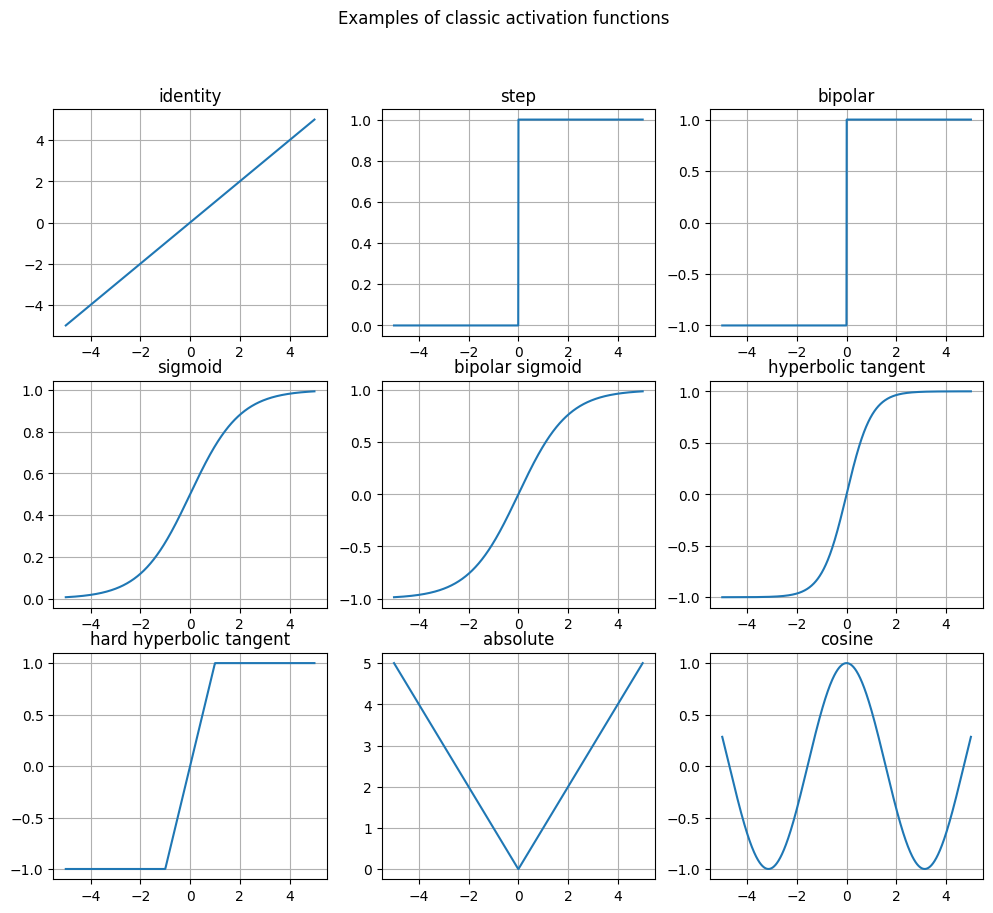

In [10]:
import numpy as np
import scipy as sp

def bsigmoid(x):
  return (1-np.exp(-x))/(1+np.exp(-x))

def hard_tanh(x):
  return np.maximum(-1, np.minimum(1, x))

t = np.linspace(-5, 5, 1000)

fig, axes = plt.subplots(3, 3, figsize=(12,10))

axes[0, 0].plot(t, t)
axes[0, 0].set_title('identity')
axes[0, 0].grid(True)

axes[0, 1].plot(t, np.heaviside(t,0))
axes[0, 1].set_title('step')
axes[0, 1].grid(True)

axes[0, 2].plot(t, np.sign(t))
axes[0, 2].set_title('bipolar')
axes[0, 2].grid(True)

axes[1, 0].plot(t, sp.special.expit(t))
axes[1, 0].set_title('sigmoid')
axes[1, 0].grid(True)

axes[1, 1].plot(t, bsigmoid(t))
axes[1, 1].set_title('bipolar sigmoid')
axes[1, 1].grid(True)

axes[1, 2].plot(t, np.tanh(t))
axes[1, 2].set_title('hyperbolic tangent')
axes[1, 2].grid(True)

axes[2, 0].plot(t, hard_tanh(t))
axes[2, 0].set_title('hard hyperbolic tangent')
axes[2, 0].grid(True)

axes[2, 1].plot(t, np.abs(t))
axes[2, 1].set_title('absolute')
axes[2, 1].grid(True)

axes[2, 2].plot(t, np.cos(t))
axes[2, 2].set_title('cosine')
axes[2, 2].grid(True)

#def zero(x):
#  return 0*x
#axes[0, 2].axvline(x=-5, ymin=0.5, ymax=0.99, color='red')
#axes[0, 2].axvline(x=5, ymin=0, ymax=0.5, color='red')
#axes[0, 2].plot(t, zero(t), color='red')

plt.suptitle('Examples of classic activation functions')
plt.show()

## 7.2.2 Rectifier-based activation functions

* Rectified Linear Unit

  $$ReLU(x) = \max(0,x)$$

  range [0, ∞]
  
  Function gets rid of the vanishing gradient problem by being not bounded in one direction.

* Leaky ReLU

  $$LReLU(x) = \begin{cases}
  x \;\;\;\;\;\;\;\;\;\;\; \text{ if } x>0 \\
  0.01 \cdot x \;\; \text{ otherwise}
  \end{cases}$$

  range [-∞,∞]
  
  Function allows unit to give a small gradient when unit is inactive, i.e. $x \leq 0$. However, it performs nearly the same as standard ReLU.

* Truncated Rectified

  $$TRec(x,t) = \begin{cases}
  x \;\; \text{ if } x>t \\
  0 \;\; \text{ otherwise}
  \end{cases}$$

  range [0, ∞]

  ReLU specialized for Deep Neural Network Autoencoders.

* Softplus

  $$softplus(x) = \log(1 + \exp(x))$$

  range [0, ∞]

  Smooth approximation of ReLU, it allows differentiation in whole domain.

* Exponential Linear Unit

  $$ELU(x, \alpha) = \begin{cases}
  x \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; \text{ if } x>0 \\
  \alpha \cdot (\exp(x) - 1) \;\; \text{ otherwise}
  \end{cases}$$

  range [-α,∞]

  Argument α controlls the value for negative inputs.

* Sigmoid-weighted Linear Unit

  $$SiLU(x) = x \cdot σ(x) = \frac{x}{1+\exp(-x)}$$

  range ≈[-0.28, ∞]

  Sigmoid function weighted by its input

* E-swish

  $$ESwish(x, \beta) = \beta \cdot x \cdot σ(x) = \frac{\beta \cdot x}{1+\exp(-x)}$$

  Similar, but with extra β parameter.

* Flatten-T Swish

  $$FTS(x, T) = \begin{cases}
  \frac{x}{1+\exp(x)} + T \;\; \text{ if } x \geq 0 \\
  T \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; \text{ otherwise}
  \end{cases}$$

  range [T, ∞]

  With $T=0$ this function becomes $ReLU(x) \cdot \sigma (x)$. *T* is addtional threshold value, it allows the function to return negative value.

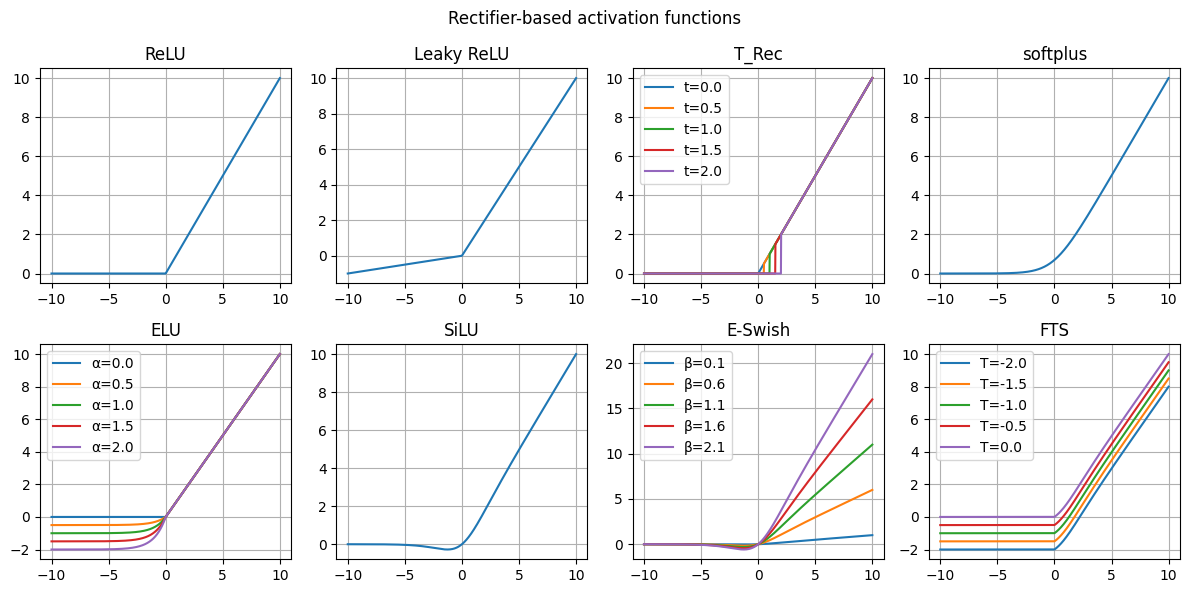

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def relu(x):
  return np.maximum(0, x)

def leaky_relu(x):
  return np.maximum(0.1*x, x)

def t_rec(x, b):
  return np.where(x > b, x, 0)

def softplus(x):
  return np.log(1+np.exp(x))

def elu(x, b):
  return np.where(x > 0, x, b*(np.exp(x)-1))

def silu(x):
  return x*sp.special.expit(x)

def eswish(x, b):
  return b*x*sp.special.expit(x)

def fts(x, T):
  return np.where(x >= 0, x*sp.special.expit(x) + T, T)

t = np.linspace(-10, 10, 1000)

fig, axes = plt.subplots(2, 4, figsize=(12,6))

axes[0, 0].plot(t, relu(t))
axes[0, 0].set_title('ReLU')
axes[0, 0].grid(True)

axes[0, 1].plot(t, leaky_relu(t))
axes[0, 1].set_title('Leaky ReLU')
axes[0, 1].grid(True)

for a in np.linspace(0,2,5):
  axes[0, 2].plot(t, t_rec(t, a), label=f't={a}')
axes[0, 2].set_title('T_Rec')
axes[0, 2].legend()
axes[0, 2].grid(True)

axes[0, 3].plot(t, softplus(t))
axes[0, 3].set_title('softplus')
axes[0, 3].grid(True)

for a in np.linspace(0,2,5):
  axes[1, 0].plot(t, elu(t, a), label=f'α={a}')
axes[1, 0].set_title('ELU')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(t, silu(t))
axes[1, 1].set_title('SiLU')
axes[1, 1].grid(True)

for a in np.linspace(0.1,2.1,5):
  axes[1, 2].plot(t, eswish(t, a), label=f'β={a}')
axes[1, 2].set_title('E-Swish')
axes[1, 2].legend()
axes[1, 2].grid(True)

for a in np.linspace(-2,0,5):
  axes[1, 3].plot(t, fts(t, a), label=f'T={a}')
axes[1, 3].set_title('FTS')
axes[1, 3].legend()
axes[1, 3].grid(True)

plt.suptitle('Rectifier-based activation functions')
plt.tight_layout()
plt.show()


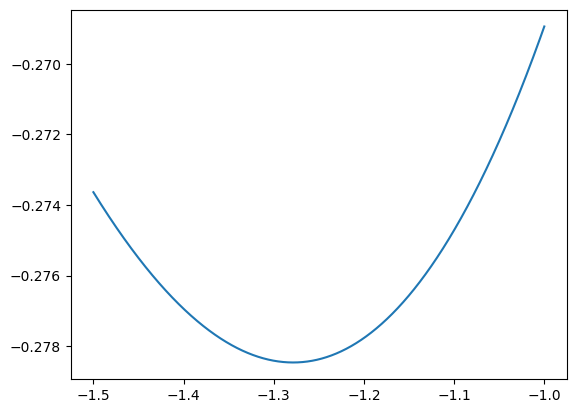

-0.2784645427610677


In [13]:
t = np.linspace(-1.5, -1, 1000000)
y = silu(t)
plt.plot(t, y)
plt.show()
print(np.min(y))